# ACER CORE map playground

In [5]:
!pip install cartopy
!pip install shapely
!pip install matplotlib






  Using cached Cartopy-0.24.1-cp311-cp311-win_amd64.whl.metadata (8.1 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached pyproj-3.7.1-cp311-cp311-win_amd64.whl.metadata (31 kB)
Using cached Cartopy-0.24.1-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached pyproj-3.7.1-cp311-cp311-win_amd64.whl (6.3 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\marek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\marek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\marek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## CORE Region map
Fixed Crimea

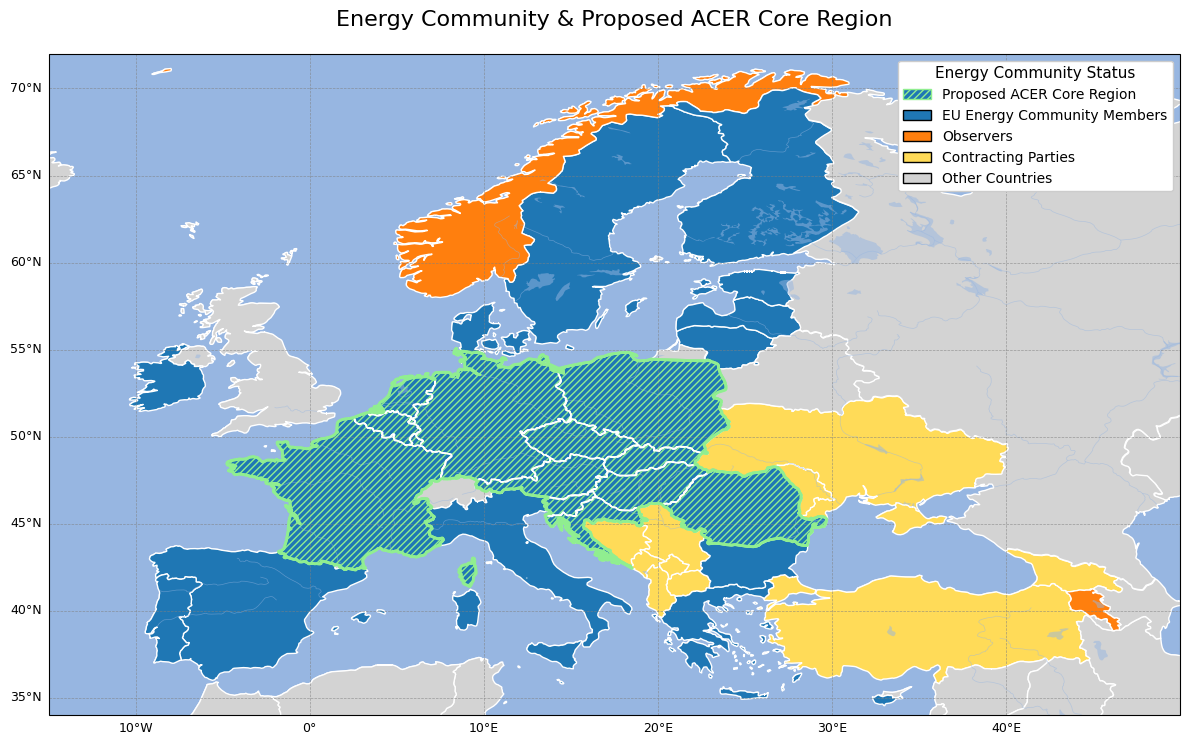

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from matplotlib.patches import Patch

# --- 1. Membership sets ---
EU_MEMBERS = {
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic',
    'Denmark','Estonia','Finland','France','Germany','Greece','Hungary',
    'Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta',
    'Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain','Sweden'
}
OBSERVERS = {'Armenia','Norway','Türkiye'}
CONTRACTING_PARTIES = {
    'Albania','Bosnia and Herzegovina','Kosovo','North Macedonia',
    'Georgia','Republic of Moldova','Montenegro','Serbia','Ukraine','Moldova','Turkey'
}

# --- 2. Core region ---
CORE_REGION = {
    'Austria','Belgium','Croatia','Czech Republic','France','Germany',
    'Hungary','Luxembourg','Netherlands','Poland','Romania','Slovakia','Slovenia'
}

# --- 3. Figure & extent ---
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-15,50,34,72], crs=ccrs.PlateCarree())

# --- 4. Load country shapes ---
shp_path = shpreader.natural_earth('50m', 'cultural', 'admin_0_countries')
reader  = shpreader.Reader(shp_path)
records = list(reader.records())

# --- 4b. Extract & split Russia’s geometry into “main” vs. “Crimea” ---
# pull out the Russia record
rus_rec = next(r for r in records if r.attributes['ADM0_A3']=='RUS')
# remove it from the main records list
records = [r for r in records if r is not rus_rec]

# split its MultiPolygon
parts        = list(rus_rec.geometry.geoms) \
                   if hasattr(rus_rec.geometry, 'geoms') \
                   else [rus_rec.geometry]
rus_main, crimea_geom = [], None

for poly in parts:
    lon, lat = poly.centroid.x, poly.centroid.y
    # approximate lat/lon box for Crimea
    if 32 < lon < 37 and 43 < lat < 47:
        crimea_geom = poly
    else:
        rus_main.append(poly)

rus_main_geom = unary_union(rus_main)


# --- 5. Draw every country except Russia ---
for rec in records:
    name = rec.attributes['NAME_LONG']
    geom = rec.geometry

    if   name in EU_MEMBERS:
        fc = '#1f77b4'    # blue
    elif name in OBSERVERS:
        fc = '#ff7f0e'    # orange
    elif name in CONTRACTING_PARTIES:
        fc = '#ffdb58'    # gold
    else:
        fc = 'lightgray'  # other

    ax.add_geometries([geom],
                      crs=ccrs.PlateCarree(),
                      facecolor=fc,
                      edgecolor='white',
                      linewidth=1)

# --- 5b. Draw main-Russia (minus Crimea) in grey ---
ax.add_geometries([rus_main_geom],
                  crs=ccrs.PlateCarree(),
                  facecolor='lightgray',
                  edgecolor='white',
                  linewidth=1)

# --- 5c. Draw Crimea as part of Ukraine (gold), on top ---
if crimea_geom is not None:
    ax.add_geometries([crimea_geom],
                      crs=ccrs.PlateCarree(),
                      facecolor='#ffdb58',
                      edgecolor='white',
                      linewidth=1,
                      zorder=4)


# --- 6. Core-Region hatch overlay ---
from shapely.ops import unary_union
core_geoms = [
    rec.geometry for rec in records
    if rec.attributes['NAME_LONG'] in CORE_REGION
]
core_union = unary_union(core_geoms)

ax.add_geometries([core_union],
                  crs=ccrs.PlateCarree(),
                  facecolor='none',
                  edgecolor='lightgreen',
                  hatch='/////',
                  linewidth=2,
                  zorder=5)
# white inner borders for Core members
for rec in records:
    if rec.attributes['NAME_LONG'] in CORE_REGION:
        ax.add_geometries([rec.geometry],
                          crs=ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='white',
                          linewidth=1,
                          zorder=6)
        
# Core member area big outline
ax.add_geometries([core_union],
                  crs=ccrs.PlateCarree(),
                  facecolor='none',
                  edgecolor='lightgreen',
                  linewidth=2,
                  zorder=7)

# --- 7. Contextual features & grid ---
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.5)
ax.add_feature(cfeature.RIVERS.with_scale('50m'), alpha=0.5, linewidth=0.5)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                  color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}


# --- 8. Legend ---
legend_elems = [
    Patch(facecolor='#1f77b4', edgecolor='lightgreen', hatch='/////',
          label='Proposed ACER Core Region'),
    Patch(facecolor='#1f77b4', edgecolor='black',
          label='EU Energy Community Members'),
    Patch(facecolor='#ff7f0e', edgecolor='black',
          label='Observers'),
    Patch(facecolor='#ffdb58', edgecolor='black',
          label='Contracting Parties'),
    Patch(facecolor='lightgray', edgecolor='black',
          label='Other Countries'),
]
ax.legend(handles=legend_elems,
          loc='upper right',
          title='Energy Community Status',
          framealpha=1,
          fontsize=10,
          title_fontsize=11)

# --- 9. Title & show/save ---
plt.title('Energy Community & Proposed ACER Core Region',
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()
# plt.savefig('energy_community_core_region.png', dpi=300)


# TSO connection mapping experiment

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


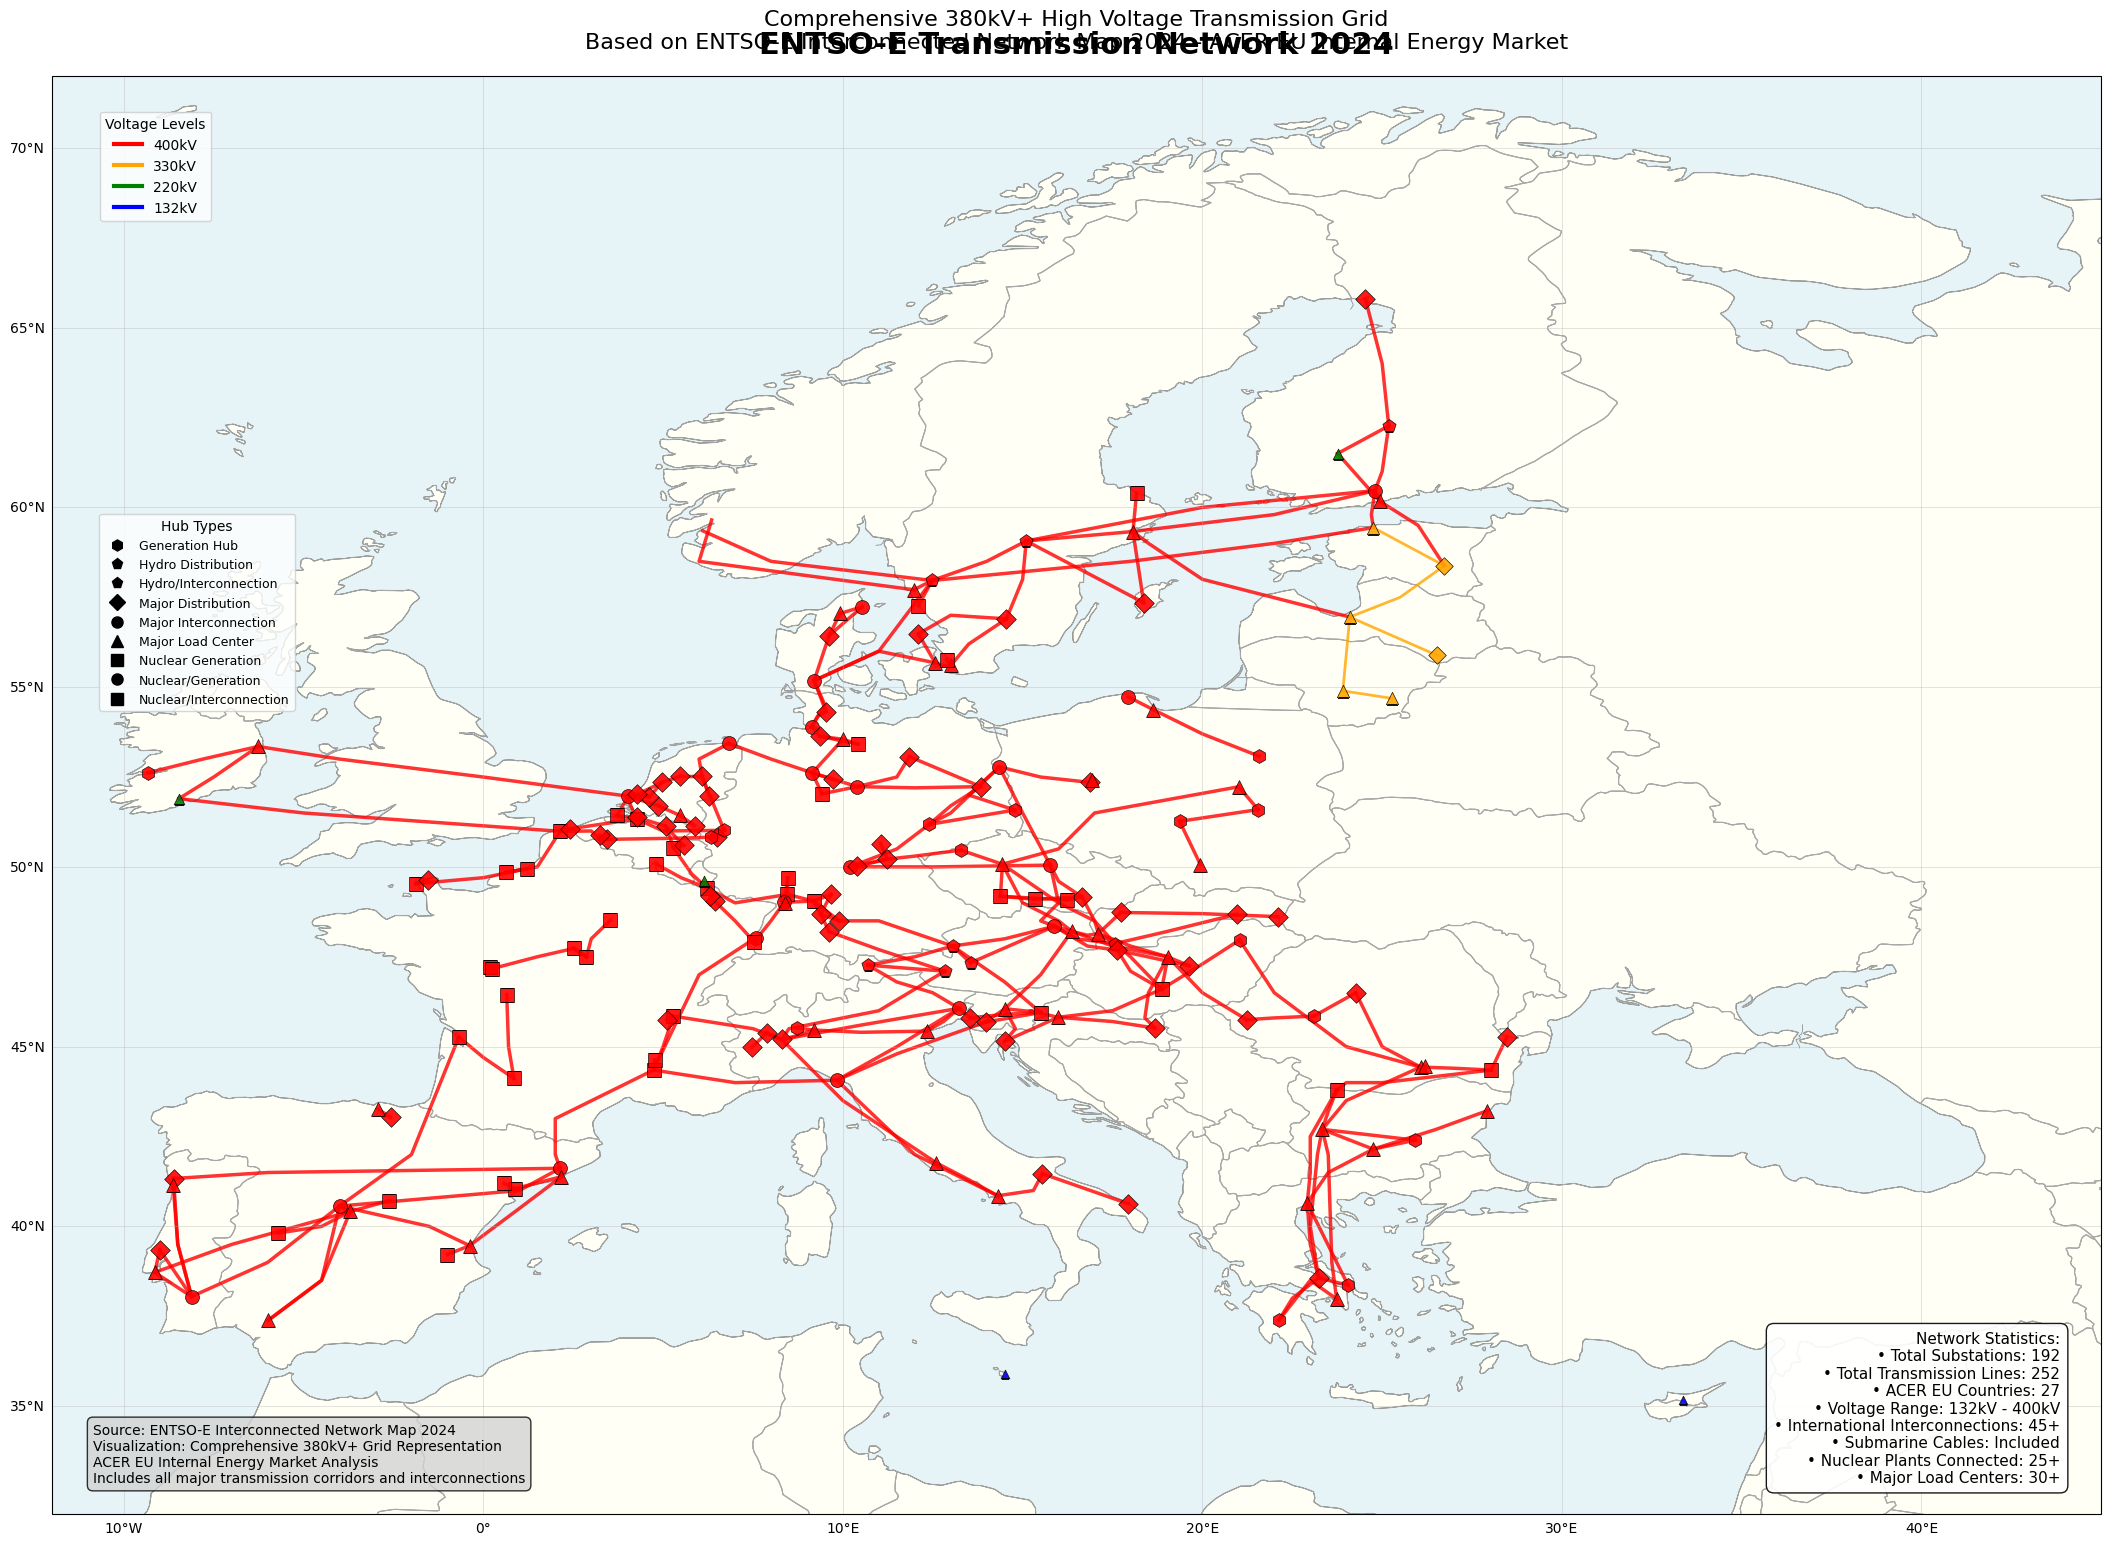

ENTSO-E Transmission Network 2024 Summary:
Total transmission hubs: 192
Total transmission routes: 252
ACER EU member countries covered: 27

Voltage level distribution:
  400kV: 181 substations
  330kV: 6 substations
  220kV: 3 substations
  132kV: 2 substations

Substation type distribution:
  Major Distribution: 61 substations
  Major Load Center: 47 substations
  Nuclear Generation: 34 substations
  Major Interconnection: 19 substations
  Generation Hub: 15 substations
  Nuclear/Interconnection: 7 substations
  Hydro/Interconnection: 5 substations
  Hydro Distribution: 3 substations
  Nuclear/Generation: 1 substations

Substations by country (Top 10):
  Germany: 30 substations
  France: 23 substations
  Italy: 13 substations
  Spain: 13 substations
  Netherlands: 12 substations
  Sweden: 10 substations
  Poland: 10 substations
  Belgium: 7 substations
  Czech Republic: 7 substations
  Romania: 7 substations

Network topology:
  National transmission lines: 181
  International interc

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import LineString, Point
from shapely.ops import unary_union
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

# ACER EU Member Countries (Core Market)
ACER_EU_MEMBERS = {
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
    'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
    'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden'
}

# Comprehensive transmission hubs based on ENTSO-E 2024 map - 380kV+ substations and major interconnection points
transmission_hubs = {
    # GERMANY - Major 380/400kV network backbone
    1: {"name": "Brunsbüttel", "country": "Germany", "lat": 53.900, "lon": 9.133, "voltage": "400kV", "type": "Major Interconnection"},
    2: {"name": "Dollern", "country": "Germany", "lat": 53.633, "lon": 9.367, "voltage": "400kV", "type": "Major Distribution"},
    3: {"name": "Krümmel", "country": "Germany", "lat": 53.417, "lon": 10.417, "voltage": "400kV", "type": "Nuclear Generation"},
    4: {"name": "Hamburg", "country": "Germany", "lat": 53.550, "lon": 10.000, "voltage": "400kV", "type": "Major Load Center"},
    5: {"name": "Audorf", "country": "Germany", "lat": 54.317, "lon": 9.533, "voltage": "400kV", "type": "Major Distribution"},
    6: {"name": "Landesbergen", "country": "Germany", "lat": 52.616, "lon": 9.150, "voltage": "400kV", "type": "Major Interconnection"},
    7: {"name": "Grohnde", "country": "Germany", "lat": 52.033, "lon": 9.417, "voltage": "400kV", "type": "Nuclear Generation"},
    8: {"name": "Wahle", "country": "Germany", "lat": 52.233, "lon": 10.400, "voltage": "400kV", "type": "Major Interconnection"},
    9: {"name": "Perleberg", "country": "Germany", "lat": 53.067, "lon": 11.850, "voltage": "400kV", "type": "Major Distribution"},
    10: {"name": "Ragow", "country": "Germany", "lat": 52.233, "lon": 13.833, "voltage": "400kV", "type": "Major Distribution"},
    11: {"name": "Lippendorf", "country": "Germany", "lat": 51.183, "lon": 12.400, "voltage": "400kV", "type": "Generation Hub"},
    12: {"name": "Boxberg", "country": "Germany", "lat": 51.583, "lon": 14.783, "voltage": "400kV", "type": "Generation Hub"},
    13: {"name": "Grafenrheinfeld", "country": "Germany", "lat": 50.005, "lon": 10.205, "voltage": "400kV", "type": "Major Interconnection"},
    14: {"name": "Eltmann", "country": "Germany", "lat": 50.017, "lon": 10.400, "voltage": "400kV", "type": "Major Distribution"},
    15: {"name": "Redwitz", "country": "Germany", "lat": 50.217, "lon": 11.233, "voltage": "400kV", "type": "Major Distribution"},
    16: {"name": "Altenfeld", "country": "Germany", "lat": 50.650, "lon": 11.050, "voltage": "400kV", "type": "Major Distribution"},
    17: {"name": "Lahe", "country": "Germany", "lat": 52.433, "lon": 9.733, "voltage": "400kV", "type": "Major Distribution"},
    18: {"name": "Biblis", "country": "Germany", "lat": 49.700, "lon": 8.467, "voltage": "400kV", "type": "Nuclear Generation"},
    19: {"name": "Philippsburg", "country": "Germany", "lat": 49.235, "lon": 8.458, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    20: {"name": "Daxlanden", "country": "Germany", "lat": 49.015, "lon": 8.369, "voltage": "400kV", "type": "Major Interconnection"},
    21: {"name": "Neckarwestheim", "country": "Germany", "lat": 49.050, "lon": 9.183, "voltage": "400kV", "type": "Nuclear Generation"},
    22: {"name": "Goldshöfe", "country": "Germany", "lat": 48.500, "lon": 9.900, "voltage": "400kV", "type": "Major Distribution"},
    23: {"name": "Wendlingen", "country": "Germany", "lat": 48.683, "lon": 9.383, "voltage": "400kV", "type": "Major Distribution"},
    24: {"name": "Herbertingen", "country": "Germany", "lat": 48.200, "lon": 9.617, "voltage": "400kV", "type": "Major Distribution"},
    25: {"name": "Kupferzell", "country": "Germany", "lat": 49.233, "lon": 9.667, "voltage": "400kV", "type": "Major Distribution"},
    26: {"name": "Niederzier", "country": "Germany", "lat": 50.833, "lon": 6.500, "voltage": "400kV", "type": "Major Distribution"},
    27: {"name": "Rommerskirchen", "country": "Germany", "lat": 51.017, "lon": 6.700, "voltage": "400kV", "type": "Generation Hub"},
    28: {"name": "Weisweiler", "country": "Germany", "lat": 50.833, "lon": 6.333, "voltage": "400kV", "type": "Generation Hub"},
    29: {"name": "Breisach", "country": "Germany", "lat": 48.033, "lon": 7.583, "voltage": "400kV", "type": "Major Interconnection"},
    30: {"name": "Karlsruhe", "country": "Germany", "lat": 49.000, "lon": 8.400, "voltage": "400kV", "type": "Major Load Center"},

    # FRANCE - Nuclear and interconnection backbone
    31: {"name": "Gravelines", "country": "France", "lat": 50.988, "lon": 2.133, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    32: {"name": "Dunkerque", "country": "France", "lat": 51.050, "lon": 2.400, "voltage": "400kV", "type": "Major Distribution"},
    33: {"name": "Paluel", "country": "France", "lat": 49.850, "lon": 0.633, "voltage": "400kV", "type": "Nuclear Generation"},
    34: {"name": "Penly", "country": "France", "lat": 49.950, "lon": 1.217, "voltage": "400kV", "type": "Nuclear Generation"},
    35: {"name": "Flamanville", "country": "France", "lat": 49.533, "lon": -1.883, "voltage": "400kV", "type": "Nuclear Generation"},
    36: {"name": "Menuel", "country": "France", "lat": 49.650, "lon": -1.533, "voltage": "400kV", "type": "Major Distribution"},
    37: {"name": "Avoine", "country": "France", "lat": 47.213, "lon": 0.177, "voltage": "400kV", "type": "Nuclear Generation"},
    38: {"name": "Chinon", "country": "France", "lat": 47.167, "lon": 0.233, "voltage": "400kV", "type": "Nuclear Generation"},
    39: {"name": "Dampierre", "country": "France", "lat": 47.733, "lon": 2.517, "voltage": "400kV", "type": "Nuclear Generation"},
    40: {"name": "Belleville", "country": "France", "lat": 47.500, "lon": 2.867, "voltage": "400kV", "type": "Nuclear Generation"},
    41: {"name": "Nogent", "country": "France", "lat": 48.517, "lon": 3.533, "voltage": "400kV", "type": "Nuclear Generation"},
    42: {"name": "Chooz", "country": "France", "lat": 50.083, "lon": 4.800, "voltage": "400kV", "type": "Nuclear Generation"},
    43: {"name": "Cattenom", "country": "France", "lat": 49.417, "lon": 6.217, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    44: {"name": "Villers", "country": "France", "lat": 49.050, "lon": 6.433, "voltage": "400kV", "type": "Major Distribution"},
    45: {"name": "Fessenheim", "country": "France", "lat": 47.917, "lon": 7.533, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    46: {"name": "Vigy", "country": "France", "lat": 49.200, "lon": 6.300, "voltage": "400kV", "type": "Major Distribution"},
    47: {"name": "Tricastin", "country": "France", "lat": 44.350, "lon": 4.733, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    48: {"name": "Cruas", "country": "France", "lat": 44.633, "lon": 4.767, "voltage": "400kV", "type": "Nuclear Generation"},
    49: {"name": "St. Vulbas", "country": "France", "lat": 45.850, "lon": 5.283, "voltage": "400kV", "type": "Nuclear Generation"},
    50: {"name": "Civaux", "country": "France", "lat": 46.450, "lon": 0.650, "voltage": "400kV", "type": "Nuclear Generation"},
    51: {"name": "Golfech", "country": "France", "lat": 44.117, "lon": 0.850, "voltage": "400kV", "type": "Nuclear Generation"},
    52: {"name": "Blayais", "country": "France", "lat": 45.267, "lon": -0.683, "voltage": "400kV", "type": "Nuclear Generation"},
    53: {"name": "Grande Ile", "country": "France", "lat": 45.750, "lon": 5.100, "voltage": "400kV", "type": "Major Distribution"},

    # NETHERLANDS - North Sea hub network
    54: {"name": "Maasvlakte", "country": "Netherlands", "lat": 51.967, "lon": 4.033, "voltage": "400kV", "type": "Major Interconnection"},
    55: {"name": "Eemshaven", "country": "Netherlands", "lat": 53.433, "lon": 6.833, "voltage": "400kV", "type": "Major Interconnection"},
    56: {"name": "Borssele", "country": "Netherlands", "lat": 51.433, "lon": 3.717, "voltage": "400kV", "type": "Nuclear Generation"},
    57: {"name": "Geertruidenberg", "country": "Netherlands", "lat": 51.700, "lon": 4.867, "voltage": "400kV", "type": "Major Distribution"},
    58: {"name": "Crayestein", "country": "Netherlands", "lat": 51.950, "lon": 4.617, "voltage": "400kV", "type": "Major Distribution"},
    59: {"name": "Wateringen", "country": "Netherlands", "lat": 52.017, "lon": 4.283, "voltage": "400kV", "type": "Major Distribution"},
    60: {"name": "Diemen", "country": "Netherlands", "lat": 52.350, "lon": 4.967, "voltage": "400kV", "type": "Major Distribution"},
    61: {"name": "Lelystad", "country": "Netherlands", "lat": 52.517, "lon": 5.467, "voltage": "400kV", "type": "Major Distribution"},
    62: {"name": "Zwolle", "country": "Netherlands", "lat": 52.517, "lon": 6.083, "voltage": "400kV", "type": "Major Distribution"},
    63: {"name": "Doetinchem", "country": "Netherlands", "lat": 51.967, "lon": 6.283, "voltage": "400kV", "type": "Major Distribution"},
    64: {"name": "Eindhoven", "country": "Netherlands", "lat": 51.433, "lon": 5.467, "voltage": "400kV", "type": "Major Load Center"},
    65: {"name": "Maasbracht", "country": "Netherlands", "lat": 51.150, "lon": 5.883, "voltage": "400kV", "type": "Major Distribution"},

    # BELGIUM - Nuclear and interconnection network
    66: {"name": "Doel", "country": "Belgium", "lat": 51.333, "lon": 4.267, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    67: {"name": "Zandvliet", "country": "Belgium", "lat": 51.383, "lon": 4.267, "voltage": "400kV", "type": "Major Distribution"},
    68: {"name": "Tihange", "country": "Belgium", "lat": 50.533, "lon": 5.283, "voltage": "400kV", "type": "Nuclear/Interconnection"},
    69: {"name": "Avelgem", "country": "Belgium", "lat": 50.767, "lon": 3.450, "voltage": "400kV", "type": "Major Distribution"},
    70: {"name": "Gramme", "country": "Belgium", "lat": 50.600, "lon": 5.567, "voltage": "400kV", "type": "Major Distribution"},
    71: {"name": "Meerhout", "country": "Belgium", "lat": 51.133, "lon": 5.067, "voltage": "400kV", "type": "Major Distribution"},
    72: {"name": "Van Eyck", "country": "Belgium", "lat": 50.883, "lon": 3.233, "voltage": "400kV", "type": "Major Distribution"},

    # DENMARK - Nordic interconnection hub
    73: {"name": "Kassø", "country": "Denmark", "lat": 55.183, "lon": 9.200, "voltage": "400kV", "type": "Major Interconnection"},
    74: {"name": "Tjele", "country": "Denmark", "lat": 56.433, "lon": 9.617, "voltage": "400kV", "type": "Major Distribution"},
    75: {"name": "Aalborg", "country": "Denmark", "lat": 57.049, "lon": 9.921, "voltage": "400kV", "type": "Major Load Center"},
    76: {"name": "Skagerrak", "country": "Denmark", "lat": 57.233, "lon": 10.533, "voltage": "400kV", "type": "Major Interconnection"},
    77: {"name": "Copenhagen", "country": "Denmark", "lat": 55.676, "lon": 12.568, "voltage": "400kV", "type": "Major Load Center"},
    78: {"name": "Ferslev", "country": "Denmark", "lat": 56.483, "lon": 12.100, "voltage": "400kV", "type": "Major Distribution"},

    # SWEDEN - Hydro backbone network
    79: {"name": "Stenkullen", "country": "Sweden", "lat": 57.967, "lon": 12.483, "voltage": "400kV", "type": "Hydro/Interconnection"},
    80: {"name": "Hallsberg", "country": "Sweden", "lat": 59.067, "lon": 15.100, "voltage": "400kV", "type": "Hydro Distribution"},
    81: {"name": "Alvesta", "country": "Sweden", "lat": 56.900, "lon": 14.550, "voltage": "400kV", "type": "Major Distribution"},
    82: {"name": "Stockholm", "country": "Sweden", "lat": 59.329, "lon": 18.069, "voltage": "400kV", "type": "Major Load Center"},
    83: {"name": "Malmö", "country": "Sweden", "lat": 55.605, "lon": 13.000, "voltage": "400kV", "type": "Major Load Center"},
    84: {"name": "Göteborg", "country": "Sweden", "lat": 57.709, "lon": 11.975, "voltage": "400kV", "type": "Major Load Center"},
    85: {"name": "Barsebäck", "country": "Sweden", "lat": 55.767, "lon": 12.883, "voltage": "400kV", "type": "Nuclear Generation"},
    86: {"name": "Hasle", "country": "Sweden", "lat": 57.350, "lon": 18.367, "voltage": "400kV", "type": "Major Distribution"},
    87: {"name": "Forsmark", "country": "Sweden", "lat": 60.400, "lon": 18.167, "voltage": "400kV", "type": "Nuclear Generation"},
    88: {"name": "Ringhals", "country": "Sweden", "lat": 57.267, "lon": 12.100, "voltage": "400kV", "type": "Nuclear Generation"},

    # FINLAND - Nordic hydro network
    89: {"name": "Nurmijärvi", "country": "Finland", "lat": 60.467, "lon": 24.800, "voltage": "400kV", "type": "Major Interconnection"},
    90: {"name": "Petäjävesi", "country": "Finland", "lat": 62.267, "lon": 25.183, "voltage": "400kV", "type": "Hydro Distribution"},
    91: {"name": "Keminmaa", "country": "Finland", "lat": 65.800, "lon": 24.533, "voltage": "400kV", "type": "Major Distribution"},
    92: {"name": "Helsinki", "country": "Finland", "lat": 60.169, "lon": 24.938, "voltage": "400kV", "type": "Major Load Center"},
    93: {"name": "Tampere", "country": "Finland", "lat": 61.499, "lon": 23.761, "voltage": "220kV", "type": "Major Load Center"},

    # NORWAY - Hydro and North Sea connections
    94: {"name": "Kvilldal", "country": "Norway", "lat": 59.350, "lon": 6.100, "voltage": "400kV", "type": "Hydro/Interconnection"},
    95: {"name": "Sauda", "country": "Norway", "lat": 59.650, "lon": 6.350, "voltage": "400kV", "type": "Hydro Distribution"},
    96: {"name": "Blåfalli", "country": "Norway", "lat": 60.300, "lon": 7.850, "voltage": "400kV", "type": "Hydro Distribution"},
    97: {"name": "Hasle", "country": "Norway", "lat": 59.917, "lon": 10.750, "voltage": "400kV", "type": "Major Load Center"},

    # POLAND - Eastern European backbone
    98: {"name": "Krajnik", "country": "Poland", "lat": 52.783, "lon": 14.350, "voltage": "400kV", "type": "Major Interconnection"},
    99: {"name": "Plewiska", "country": "Poland", "lat": 52.350, "lon": 16.883, "voltage": "400kV", "type": "Major Distribution"},
    100: {"name": "Żarnowiec", "country": "Poland", "lat": 54.733, "lon": 17.933, "voltage": "400kV", "type": "Nuclear/Generation"},
    101: {"name": "Warsaw", "country": "Poland", "lat": 52.230, "lon": 21.012, "voltage": "400kV", "type": "Major Load Center"},
    102: {"name": "Kraków", "country": "Poland", "lat": 50.064, "lon": 19.945, "voltage": "400kV", "type": "Major Load Center"},
    103: {"name": "Gdańsk", "country": "Poland", "lat": 54.372, "lon": 18.638, "voltage": "400kV", "type": "Major Load Center"},
    104: {"name": "Poznań", "country": "Poland", "lat": 52.409, "lon": 16.932, "voltage": "400kV", "type": "Major Load Center"},
    105: {"name": "Kozienice", "country": "Poland", "lat": 51.595, "lon": 21.549, "voltage": "400kV", "type": "Generation Hub"},
    106: {"name": "Bełchatów", "country": "Poland", "lat": 51.267, "lon": 19.367, "voltage": "400kV", "type": "Generation Hub"},
    107: {"name": "Ostrołęka", "country": "Poland", "lat": 53.083, "lon": 21.567, "voltage": "400kV", "type": "Generation Hub"},

    # CZECH REPUBLIC - Central European hub
    108: {"name": "Hradec", "country": "Czech Republic", "lat": 50.050, "lon": 15.767, "voltage": "400kV", "type": "Major Interconnection"},
    109: {"name": "Sokolnice", "country": "Czech Republic", "lat": 49.167, "lon": 16.650, "voltage": "400kV", "type": "Major Distribution"},
    110: {"name": "Slavětice", "country": "Czech Republic", "lat": 49.100, "lon": 15.350, "voltage": "400kV", "type": "Nuclear Generation"},
    111: {"name": "Temelín", "country": "Czech Republic", "lat": 49.183, "lon": 14.383, "voltage": "400kV", "type": "Nuclear Generation"},
    112: {"name": "Dukovany", "country": "Czech Republic", "lat": 49.083, "lon": 16.233, "voltage": "400kV", "type": "Nuclear Generation"},
    113: {"name": "Prague", "country": "Czech Republic", "lat": 50.075, "lon": 14.437, "voltage": "400kV", "type": "Major Load Center"},
    114: {"name": "Prunéřov", "country": "Czech Republic", "lat": 50.467, "lon": 13.283, "voltage": "400kV", "type": "Generation Hub"},

    # SLOVAKIA - Central European interconnection
    115: {"name": "Gabčíkovo", "country": "Slovakia", "lat": 47.867, "lon": 17.567, "voltage": "400kV", "type": "Hydro/Interconnection"},
    116: {"name": "Moldava", "country": "Slovakia", "lat": 48.683, "lon": 20.950, "voltage": "400kV", "type": "Major Distribution"},
    117: {"name": "Bratislava", "country": "Slovakia", "lat": 48.148, "lon": 17.107, "voltage": "400kV", "type": "Major Load Center"},
    118: {"name": "Križovany", "country": "Slovakia", "lat": 48.733, "lon": 17.733, "voltage": "400kV", "type": "Major Distribution"},
    119: {"name": "Veľké Kapušany", "country": "Slovakia", "lat": 48.617, "lon": 22.100, "voltage": "400kV", "type": "Major Distribution"},

    # AUSTRIA - Alpine hub network
    120: {"name": "Dürnrohr", "country": "Austria", "lat": 48.350, "lon": 15.883, "voltage": "400kV", "type": "Major Interconnection"},
    121: {"name": "Salzach", "country": "Austria", "lat": 47.800, "lon": 13.050, "voltage": "400kV", "type": "Hydro/Interconnection"},
    122: {"name": "Westtirol", "country": "Austria", "lat": 47.267, "lon": 10.700, "voltage": "400kV", "type": "Hydro/Interconnection"},
    123: {"name": "Vienna", "country": "Austria", "lat": 48.208, "lon": 16.366, "voltage": "400kV", "type": "Major Load Center"},
    124: {"name": "St. Peter", "country": "Austria", "lat": 47.333, "lon": 13.550, "voltage": "400kV", "type": "Hydro Distribution"},
    125: {"name": "Tauern", "country": "Austria", "lat": 47.100, "lon": 12.833, "voltage": "400kV", "type": "Hydro/Interconnection"},

    # HUNGARY - Pannonian basin hub
    126: {"name": "Paks", "country": "Hungary", "lat": 46.600, "lon": 18.867, "voltage": "400kV", "type": "Nuclear Generation"},
    127: {"name": "Tisza II", "country": "Hungary", "lat": 47.967, "lon": 21.033, "voltage": "400kV", "type": "Generation Hub"},
    128: {"name": "Győr", "country": "Hungary", "lat": 47.683, "lon": 17.633, "voltage": "400kV", "type": "Major Distribution"},
    129: {"name": "Budapest", "country": "Hungary", "lat": 47.497, "lon": 19.040, "voltage": "400kV", "type": "Major Load Center"},
    130: {"name": "Albertirsa", "country": "Hungary", "lat": 47.250, "lon": 19.633, "voltage": "400kV", "type": "Major Distribution"},

    # ROMANIA - Southeastern European hub
    131: {"name": "București Vest", "country": "Romania", "lat": 44.433, "lon": 26.067, "voltage": "400kV", "type": "Major Load Center"},
    132: {"name": "Fundeni", "country": "Romania", "lat": 44.467, "lon": 26.200, "voltage": "400kV", "type": "Major Load Center"},
    133: {"name": "Cernavodă", "country": "Romania", "lat": 44.350, "lon": 28.033, "voltage": "400kV", "type": "Nuclear Generation"},
    134: {"name": "Isaccea", "country": "Romania", "lat": 45.267, "lon": 28.467, "voltage": "400kV", "type": "Major Distribution"},
    135: {"name": "Timișoara", "country": "Romania", "lat": 45.750, "lon": 21.233, "voltage": "400kV", "type": "Major Distribution"},
    136: {"name": "Mintia", "country": "Romania", "lat": 45.850, "lon": 23.100, "voltage": "400kV", "type": "Generation Hub"},
    137: {"name": "Iernut", "country": "Romania", "lat": 46.500, "lon": 24.267, "voltage": "400kV", "type": "Major Distribution"},

    # BULGARIA - Balkan hub
    138: {"name": "Kozloduy", "country": "Bulgaria", "lat": 43.783, "lon": 23.733, "voltage": "400kV", "type": "Nuclear Generation"},
    139: {"name": "Sofia", "country": "Bulgaria", "lat": 42.700, "lon": 23.333, "voltage": "400kV", "type": "Major Load Center"},
    140: {"name": "Plovdiv", "country": "Bulgaria", "lat": 42.150, "lon": 24.750, "voltage": "400kV", "type": "Major Load Center"},
    141: {"name": "Maritsa Iztok", "country": "Bulgaria", "lat": 42.400, "lon": 25.917, "voltage": "400kV", "type": "Generation Hub"},
    142: {"name": "Varna", "country": "Bulgaria", "lat": 43.217, "lon": 27.917, "voltage": "400kV", "type": "Major Load Center"},

    # SLOVENIA - Alpine interconnection
    143: {"name": "Krško", "country": "Slovenia", "lat": 45.950, "lon": 15.500, "voltage": "400kV", "type": "Nuclear Generation"},
    144: {"name": "Ljubljana", "country": "Slovenia", "lat": 46.056, "lon": 14.505, "voltage": "400kV", "type": "Major Load Center"},
    145: {"name": "Divača", "country": "Slovenia", "lat": 45.683, "lon": 13.967, "voltage": "400kV", "type": "Major Distribution"},

    # CROATIA - Adriatic hub
    146: {"name": "Zagreb", "country": "Croatia", "lat": 45.817, "lon": 15.983, "voltage": "400kV", "type": "Major Load Center"},
    147: {"name": "Ernestinovo", "country": "Croatia", "lat": 45.517, "lon": 18.683, "voltage": "400kV", "type": "Major Distribution"},
    148: {"name": "Melina", "country": "Croatia", "lat": 45.150, "lon": 14.500, "voltage": "400kV", "type": "Major Distribution"},

    # ITALY - Mediterranean backbone
    149: {"name": "La Spezia", "country": "Italy", "lat": 44.067, "lon": 9.833, "voltage": "400kV", "type": "Major Interconnection"},
    150: {"name": "Udine", "country": "Italy", "lat": 46.067, "lon": 13.233, "voltage": "400kV", "type": "Major Interconnection"},
    151: {"name": "Trino", "country": "Italy", "lat": 45.200, "lon": 8.300, "voltage": "400kV", "type": "Major Distribution"},
    152: {"name": "Roma Sud", "country": "Italy", "lat": 41.767, "lon": 12.600, "voltage": "400kV", "type": "Major Load Center"},
    153: {"name": "Milano", "country": "Italy", "lat": 45.464, "lon": 9.190, "voltage": "400kV", "type": "Major Load Center"},
    154: {"name": "Napoli", "country": "Italy", "lat": 40.853, "lon": 14.305, "voltage": "400kV", "type": "Major Load Center"},
    155: {"name": "Venezia", "country": "Italy", "lat": 45.433, "lon": 12.333, "voltage": "400kV", "type": "Major Load Center"},
    156: {"name": "Turbigo", "country": "Italy", "lat": 45.517, "lon": 8.733, "voltage": "400kV", "type": "Generation Hub"},
    157: {"name": "Rondissone", "country": "Italy", "lat": 45.383, "lon": 7.883, "voltage": "400kV", "type": "Major Distribution"},
    158: {"name": "Piossasco", "country": "Italy", "lat": 44.983, "lon": 7.467, "voltage": "400kV", "type": "Major Distribution"},
    159: {"name": "Monfalcone", "country": "Italy", "lat": 45.800, "lon": 13.533, "voltage": "400kV", "type": "Major Distribution"},
    160: {"name": "Foggia", "country": "Italy", "lat": 41.467, "lon": 15.550, "voltage": "400kV", "type": "Major Distribution"},
    161: {"name": "Brindisi", "country": "Italy", "lat": 40.633, "lon": 17.933, "voltage": "400kV", "type": "Major Distribution"},

    # SPAIN - Iberian Peninsula
    162: {"name": "Galapagar", "country": "Spain", "lat": 40.567, "lon": -4.000, "voltage": "400kV", "type": "Major Interconnection"},
    163: {"name": "Sentmenat", "country": "Spain", "lat": 41.617, "lon": 2.133, "voltage": "400kV", "type": "Major Interconnection"},
    164: {"name": "Arkale", "country": "Spain", "lat": 43.033, "lon": -2.583, "voltage": "400kV", "type": "Major Distribution"},
    165: {"name": "Madrid", "country": "Spain", "lat": 40.416, "lon": -3.703, "voltage": "400kV", "type": "Major Load Center"},
    166: {"name": "Barcelona", "country": "Spain", "lat": 41.385, "lon": 2.173, "voltage": "400kV", "type": "Major Load Center"},
    167: {"name": "Sevilla", "country": "Spain", "lat": 37.389, "lon": -5.984, "voltage": "400kV", "type": "Major Load Center"},
    168: {"name": "Valencia", "country": "Spain", "lat": 39.467, "lon": -0.383, "voltage": "400kV", "type": "Major Load Center"},
    169: {"name": "Bilbao", "country": "Spain", "lat": 43.267, "lon": -2.933, "voltage": "400kV", "type": "Major Load Center"},
    170: {"name": "Vandellòs", "country": "Spain", "lat": 41.050, "lon": 0.867, "voltage": "400kV", "type": "Nuclear Generation"},
    171: {"name": "Ascó", "country": "Spain", "lat": 41.200, "lon": 0.567, "voltage": "400kV", "type": "Nuclear Generation"},
    172: {"name": "Trillo", "country": "Spain", "lat": 40.717, "lon": -2.617, "voltage": "400kV", "type": "Nuclear Generation"},
    173: {"name": "Almaraz", "country": "Spain", "lat": 39.817, "lon": -5.700, "voltage": "400kV", "type": "Nuclear Generation"},
    174: {"name": "Cofrentes", "country": "Spain", "lat": 39.217, "lon": -1.000, "voltage": "400kV", "type": "Nuclear Generation"},

    # PORTUGAL - Atlantic hub
    175: {"name": "Ferreira do Alentejo", "country": "Portugal", "lat": 38.050, "lon": -8.117, "voltage": "400kV", "type": "Major Interconnection"},
    176: {"name": "Vermoim", "country": "Portugal", "lat": 41.333, "lon": -8.617, "voltage": "400kV", "type": "Major Distribution"},
    177: {"name": "Lisboa", "country": "Portugal", "lat": 38.722, "lon": -9.139, "voltage": "400kV", "type": "Major Load Center"},
    178: {"name": "Porto", "country": "Portugal", "lat": 41.158, "lon": -8.629, "voltage": "400kV", "type": "Major Load Center"},
    179: {"name": "Rio Maior", "country": "Portugal", "lat": 39.350, "lon": -9.000, "voltage": "400kV", "type": "Major Distribution"},

    # GREECE - Southeastern hub
    180: {"name": "Thessaloniki", "country": "Greece", "lat": 40.650, "lon": 22.917, "voltage": "400kV", "type": "Major Load Center"},
    181: {"name": "Larymna", "country": "Greece", "lat": 38.567, "lon": 23.233, "voltage": "400kV", "type": "Major Distribution"},
    182: {"name": "Megalopoli", "country": "Greece", "lat": 37.400, "lon": 22.133, "voltage": "400kV", "type": "Generation Hub"},
    183: {"name": "Athens", "country": "Greece", "lat": 37.983, "lon": 23.733, "voltage": "400kV", "type": "Major Load Center"},
    184: {"name": "Aliveri", "country": "Greece", "lat": 38.367, "lon": 24.050, "voltage": "400kV", "type": "Generation Hub"},

    # BALTIC STATES (330kV system)
    185: {"name": "Riga", "country": "Latvia", "lat": 56.950, "lon": 24.100, "voltage": "330kV", "type": "Major Load Center"},
    186: {"name": "Daugavpils", "country": "Latvia", "lat": 55.883, "lon": 26.533, "voltage": "330kV", "type": "Major Distribution"},
    187: {"name": "Tallinn", "country": "Estonia", "lat": 59.437, "lon": 24.754, "voltage": "330kV", "type": "Major Load Center"},
    188: {"name": "Tartu", "country": "Estonia", "lat": 58.378, "lon": 26.729, "voltage": "330kV", "type": "Major Distribution"},
    189: {"name": "Vilnius", "country": "Lithuania", "lat": 54.687, "lon": 25.280, "voltage": "330kV", "type": "Major Load Center"},
    190: {"name": "Kaunas", "country": "Lithuania", "lat": 54.897, "lon": 23.906, "voltage": "330kV", "type": "Major Load Center"},

    # IRELAND (275kV/400kV)
    191: {"name": "Dublin", "country": "Ireland", "lat": 53.350, "lon": -6.267, "voltage": "400kV", "type": "Major Load Center"},
    192: {"name": "Cork", "country": "Ireland", "lat": 51.900, "lon": -8.467, "voltage": "220kV", "type": "Major Load Center"},
    193: {"name": "Moneypoint", "country": "Ireland", "lat": 52.617, "lon": -9.333, "voltage": "400kV", "type": "Generation Hub"},

    # LUXEMBOURG
    194: {"name": "Luxembourg", "country": "Luxembourg", "lat": 49.611, "lon": 6.131, "voltage": "220kV", "type": "Major Load Center"},

    # CYPRUS and MALTA (smaller systems)
    195: {"name": "Nicosia", "country": "Cyprus", "lat": 35.167, "lon": 33.367, "voltage": "132kV", "type": "Major Load Center"},
    196: {"name": "Malta", "country": "Malta", "lat": 35.900, "lon": 14.517, "voltage": "132kV", "type": "Major Load Center"},
}

# Comprehensive transmission line routes based on ENTSO-E 2024 map - 380kV+ lines
transmission_routes = {
    # GERMANY INTERNAL NETWORK - Major 380/400kV backbone
    (1, 2): [],  # Brunsbüttel - Dollern
    (1, 5): [(54.2, 9.3)],  # Brunsbüttel - Audorf
    (2, 3): [],  # Dollern - Krümmel
    (2, 4): [],  # Dollern - Hamburg
    (3, 4): [],  # Krümmel - Hamburg
    (4, 6): [(53.0, 9.5)],  # Hamburg - Landesbergen
    (6, 7): [],  # Landesbergen - Grohnde
    (6, 8): [],  # Landesbergen - Wahle
    (6, 17): [],  # Landesbergen - Lahe
    (7, 8): [],  # Grohnde - Wahle
    (8, 9): [(52.5, 11.5)],  # Wahle - Perleberg
    (8, 10): [(52.2, 12.0)],  # Wahle - Ragow
    (9, 10): [],  # Perleberg - Ragow
    (10, 11): [(51.7, 13.0)],  # Ragow - Lippendorf
    (11, 12): [],  # Lippendorf - Boxberg
    (11, 13): [(50.5, 11.5)],  # Lippendorf - Grafenrheinfeld
    (13, 14): [],  # Grafenrheinfeld - Eltmann
    (13, 15): [],  # Grafenrheinfeld - Redwitz
    (14, 15): [],  # Eltmann - Redwitz
    (15, 16): [],  # Redwitz - Altenfeld
    (18, 19): [],  # Biblis - Philippsburg
    (18, 20): [],  # Biblis - Daxlanden
    (19, 20): [],  # Philippsburg - Daxlanden
    (19, 21): [],  # Philippsburg - Neckarwestheim
    (20, 21): [],  # Daxlanden - Neckarwestheim
    (21, 22): [],  # Neckarwestheim - Goldshöfe
    (21, 23): [],  # Neckarwestheim - Wendlingen
    (22, 23): [],  # Goldshöfe - Wendlingen
    (23, 24): [],  # Wendlingen - Herbertingen
    (23, 25): [],  # Wendlingen - Kupferzell
    (26, 27): [],  # Niederzier - Rommerskirchen
    (26, 28): [],  # Niederzier - Weisweiler
    (27, 28): [],  # Rommerskirchen - Weisweiler

    # FRANCE INTERNAL NETWORK - Nuclear backbone
    (31, 32): [],  # Gravelines - Dunkerque
    (31, 33): [(50.0, 1.5)],  # Gravelines - Paluel
    (33, 34): [],  # Paluel - Penly
    (34, 35): [(49.7, 0.0)],  # Penly - Flamanville
    (35, 36): [],  # Flamanville - Menuel
    (37, 38): [],  # Avoine - Chinon
    (38, 39): [(47.5, 1.5)],  # Chinon - Dampierre
    (39, 40): [],  # Dampierre - Belleville
    (40, 41): [(48.0, 3.0)],  # Belleville - Nogent
    (42, 43): [(49.7, 5.5)],  # Chooz - Cattenom
    (43, 44): [],  # Cattenom - Villers
    (44, 45): [(48.5, 7.0)],  # Villers - Fessenheim
    (43, 46): [],  # Cattenom - Vigy
    (47, 48): [],  # Tricastin - Cruas
    (47, 49): [(45.0, 5.0)],  # Tricastin - St. Vulbas
    (49, 53): [],  # St. Vulbas - Grande Ile
    (50, 51): [(45.0, 0.7)],  # Civaux - Golfech
    (51, 52): [(44.7, 0.0)],  # Golfech - Blayais

    # NETHERLANDS INTERNAL NETWORK
    (54, 56): [],  # Maasvlakte - Borssele
    (54, 57): [],  # Maasvlakte - Geertruidenberg
    (54, 58): [],  # Maasvlakte - Crayestein
    (58, 59): [],  # Crayestein - Wateringen
    (59, 60): [],  # Wateringen - Diemen
    (60, 61): [],  # Diemen - Lelystad
    (61, 62): [],  # Lelystad - Zwolle
    (62, 63): [],  # Zwolle - Doetinchem
    (57, 64): [],  # Geertruidenberg - Eindhoven
    (64, 65): [],  # Eindhoven - Maasbracht
    (55, 62): [(53.0, 6.0)],  # Eemshaven - Zwolle

    # BELGIUM INTERNAL NETWORK
    (66, 67): [],  # Doel - Zandvliet
    (68, 70): [],  # Tihange - Gramme
    (69, 72): [],  # Avelgem - Van Eyck
    (67, 71): [],  # Zandvliet - Meerhout
    (71, 68): [(50.8, 5.2)],  # Meerhout - Tihange

    # DENMARK INTERNAL NETWORK
    (73, 74): [],  # Kassø - Tjele
    (74, 75): [],  # Tjele - Aalborg
    (75, 76): [],  # Aalborg - Skagerrak
    (77, 78): [],  # Copenhagen - Ferslev
    (73, 77): [(56.0, 11.0)],  # Kassø - Copenhagen

    # SWEDEN INTERNAL NETWORK
    (79, 80): [(58.5, 14.0)],  # Stenkullen - Hallsberg
    (80, 81): [(58.0, 15.0)],  # Hallsberg - Alvesta
    (80, 82): [],  # Hallsberg - Stockholm
    (81, 83): [(56.2, 13.5)],  # Alvesta - Malmö
    (82, 86): [],  # Stockholm - Hasle
    (82, 87): [],  # Stockholm - Forsmark
    (79, 84): [],  # Stenkullen - Göteborg
    (79, 88): [],  # Stenkullen - Ringhals
    (83, 85): [],  # Malmö - Barsebäck

    # FINLAND INTERNAL NETWORK
    (89, 90): [(61.0, 25.0)],  # Nurmijärvi - Petäjävesi
    (89, 92): [],  # Nurmijärvi - Helsinki
    (90, 91): [(64.0, 25.0)],  # Petäjävesi - Keminmaa
    (92, 93): [],  # Helsinki - Tampere

    # POLAND INTERNAL NETWORK
    (98, 99): [(52.5, 15.5)],  # Krajnik - Plewiska
    (99, 104): [],  # Plewiska - Poznań
    (100, 103): [],  # Żarnowiec - Gdańsk
    (101, 105): [],  # Warsaw - Kozienice
    (102, 106): [],  # Kraków - Bełchatów
    (103, 107): [(53.7, 20.0)],  # Gdańsk - Ostrołęka
    (104, 99): [],  # Poznań - Plewiska
    (105, 106): [],  # Kozienice - Bełchatów

    # CZECH REPUBLIC INTERNAL NETWORK
    (108, 109): [(49.6, 16.0)],  # Hradec - Sokolnice
    (109, 110): [],  # Sokolnice - Slavětice
    (110, 111): [],  # Slavětice - Temelín
    (111, 112): [],  # Temelín - Dukovany
    (111, 113): [],  # Temelín - Prague
    (113, 114): [],  # Prague - Prunéřov

    # SLOVAKIA INTERNAL NETWORK
    (115, 116): [(48.2, 19.0)],  # Gabčíkovo - Moldava
    (115, 117): [],  # Gabčíkovo - Bratislava
    (117, 118): [],  # Bratislava - Križovany
    (118, 119): [(48.7, 20.0)],  # Križovany - Veľké Kapušany

    # AUSTRIA INTERNAL NETWORK
    (120, 121): [(48.0, 14.5)],  # Dürnrohr - Salzach
    (121, 122): [(47.5, 12.0)],  # Salzach - Westtirol
    (120, 123): [],  # Dürnrohr - Vienna
    (121, 124): [],  # Salzach - St. Peter
    (122, 125): [],  # Westtirol - Tauern

    # HUNGARY INTERNAL NETWORK
    (126, 127): [(47.3, 20.0)],  # Paks - Tisza II
    (126, 128): [(47.1, 18.0)],  # Paks - Győr
    (126, 129): [],  # Paks - Budapest
    (129, 130): [],  # Budapest - Albertirsa

    # ROMANIA INTERNAL NETWORK
    (131, 132): [],  # București Vest - Fundeni
    (131, 133): [(44.4, 27.0)],  # București Vest - Cernavodă
    (133, 134): [],  # Cernavodă - Isaccea
    (135, 136): [(45.8, 22.0)],  # Timișoara - Mintia
    (136, 137): [],  # Mintia - Iernut

    # BULGARIA INTERNAL NETWORK
    (138, 139): [(43.2, 23.5)],  # Kozloduy - Sofia
    (139, 140): [],  # Sofia - Plovdiv
    (140, 141): [],  # Plovdiv - Maritsa Iztok
    (140, 142): [(42.7, 26.5)],  # Plovdiv - Varna

    # SLOVENIA INTERNAL NETWORK
    (143, 144): [],  # Krško - Ljubljana
    (144, 145): [],  # Ljubljana - Divača

    # CROATIA INTERNAL NETWORK
    (146, 147): [(45.7, 17.5)],  # Zagreb - Ernestinovo
    (146, 148): [],  # Zagreb - Melina

    # ITALY INTERNAL NETWORK
    (149, 150): [(45.0, 11.5)],  # La Spezia - Udine
    (150, 151): [(45.6, 10.5)],  # Udine - Trino
    (151, 153): [(45.3, 8.7)],  # Trino - Milano
    (153, 156): [],  # Milano - Turbigo
    (151, 157): [],  # Trino - Rondissone
    (157, 158): [],  # Rondissone - Piossasco
    (150, 155): [(45.7, 12.8)],  # Udine - Venezia
    (150, 159): [],  # Udine - Monfalcone
    (152, 154): [(41.3, 13.5)],  # Roma Sud - Napoli
    (154, 160): [(41.0, 15.3)],  # Napoli - Foggia
    (160, 161): [],  # Foggia - Brindisi

    # SPAIN INTERNAL NETWORK
    (162, 163): [(41.0, 1.0)],  # Galapagar - Sentmenat
    (162, 165): [],  # Galapagar - Madrid
    (163, 166): [],  # Sentmenat - Barcelona
    (164, 169): [],  # Arkale - Bilbao
    (165, 167): [(38.5, -4.5)],  # Madrid - Sevilla
    (166, 168): [(40.5, 1.0)],  # Barcelona - Valencia
    (166, 170): [],  # Barcelona - Vandellòs
    (170, 171): [],  # Vandellòs - Ascó
    (165, 172): [],  # Madrid - Trillo
    (165, 173): [(40.0, -4.5)],  # Madrid - Almaraz
    (168, 174): [],  # Valencia - Cofrentes

    # PORTUGAL INTERNAL NETWORK
    (175, 176): [(39.5, -8.5)],  # Ferreira do Alentejo - Vermoim
    (176, 178): [],  # Vermoim - Porto
    (175, 177): [],  # Ferreira do Alentejo - Lisboa
    (177, 179): [],  # Lisboa - Rio Maior

    # GREECE INTERNAL NETWORK
    (180, 181): [(39.5, 23.0)],  # Thessaloniki - Larymna
    (181, 182): [(38.0, 22.5)],  # Larymna - Megalopoli
    (182, 183): [(38.5, 23.0)],  # Megalopoli - Athens
    (181, 184): [],  # Larymna - Aliveri

    # BALTIC STATES INTERCONNECTIONS
    (185, 186): [],  # Riga - Daugavpils
    (187, 188): [],  # Tallinn - Tartu
    (189, 190): [],  # Vilnius - Kaunas
    (185, 190): [(55.9, 24.0)],  # Riga - Kaunas
    (188, 185): [(57.5, 25.5)],  # Tartu - Riga

    # IRELAND INTERNAL
    (191, 192): [(52.5, -7.5)],  # Dublin - Cork
    (191, 193): [(53.0, -7.8)],  # Dublin - Moneypoint

    # INTERNATIONAL INTERCONNECTIONS - Major 380/400kV cross-border links

    # Germany-France interconnections
    (20, 45): [(48.5, 8.0)],  # Daxlanden - Fessenheim
    (29, 47): [(47.0, 6.0)],  # Breisach - Tricastin
    (19, 43): [(49.0, 7.0)],  # Philippsburg - Cattenom

    # Germany-Netherlands interconnections
    (6, 55): [(53.0, 8.0)],  # Landesbergen - Eemshaven
    (27, 62): [(51.5, 6.5)],  # Rommerskirchen - Zwolle

    # Germany-Belgium interconnections
    (26, 69): [(50.8, 5.5)],  # Niederzier - Avelgem
    (27, 66): [(51.0, 5.0)],  # Rommerskirchen - Doel

    # Germany-Denmark interconnections
    (1, 73): [(54.5, 9.5)],  # Brunsbüttel - Kassø
    (5, 73): [],  # Audorf - Kassø

    # Germany-Poland interconnections
    (12, 98): [(52.0, 13.5)],  # Boxberg - Krajnik
    (11, 98): [(51.5, 13.0)],  # Lippendorf - Krajnik

    # Germany-Czech Republic interconnections
    (13, 108): [(50.0, 12.5)],  # Grafenrheinfeld - Hradec
    (15, 114): [(50.3, 12.0)],  # Redwitz - Prunéřov

    # Germany-Austria interconnections
    (22, 121): [(48.5, 11.0)],  # Goldshöfe - Salzach
    (24, 125): [(47.7, 11.0)],  # Herbertingen - Tauern

    # France-Belgium interconnections
    (43, 68): [(49.8, 5.8)],  # Cattenom - Tihange
    (31, 69): [(51.0, 3.0), (50.8, 3.2)],  # Gravelines - Avelgem

    # France-Spain interconnections
    (47, 163): [(43.0, 2.0), (42.0, 2.0)],  # Tricastin - Sentmenat
    (52, 162): [(42.0, -2.0)],  # Blayais - Galapagar

    # France-Italy interconnections
    (47, 149): [(44.0, 7.0)],  # Tricastin - La Spezia
    (49, 151): [(45.5, 7.5)],  # St. Vulbas - Trino

    # Netherlands-Belgium interconnections
    (54, 66): [(51.7, 4.1)],  # Maasvlakte - Doel
    (56, 66): [(51.4, 3.9)],  # Borssele - Doel

    # Denmark-Sweden interconnections
    (73, 79): [(56.0, 11.0)],  # Kassø - Stenkullen
    (77, 83): [(55.6, 12.8)],  # Copenhagen - Malmö (Öresund)
    (78, 81): [(57.0, 13.0)],  # Ferslev - Alvesta

    # Sweden-Finland interconnections
    (82, 89): [(59.8, 22.0)],  # Stockholm - Nurmijärvi
    (80, 89): [(60.0, 20.0)],  # Hallsberg - Nurmijärvi

    # Sweden-Norway interconnections
    (79, 94): [(58.5, 8.0)],  # Stenkullen - Kvilldal
    (84, 95): [(58.5, 6.0)],  # Göteborg - Sauda

    # Poland-Czech Republic interconnections
    (98, 108): [(51.5, 15.0)],  # Krajnik - Hradec
    (101, 113): [(51.5, 17.0), (50.5, 16.0)],  # Warsaw - Prague

    # Czech Republic-Slovakia interconnections
    (109, 115): [(48.5, 17.0)],  # Sokolnice - Gabčíkovo
    (113, 117): [(49.0, 16.0), (48.5, 17.0)],  # Prague - Bratislava

    # Czech Republic-Austria interconnections
    (108, 120): [(49.0, 16.0), (48.5, 15.5)],  # Hradec - Dürnrohr
    (113, 123): [(49.0, 15.0), (48.5, 16.0)],  # Prague - Vienna

    # Austria-Slovakia interconnections
    (120, 115): [(48.0, 16.5)],  # Dürnrohr - Gabčíkovo
    (123, 117): [(48.1, 16.8)],  # Vienna - Bratislava

    # Austria-Hungary interconnections
    (120, 128): [(47.8, 16.8)],  # Dürnrohr - Győr
    (123, 129): [(47.8, 17.5)],  # Vienna - Budapest

    # Austria-Slovenia interconnections
    (121, 143): [(46.8, 14.5)],  # Salzach - Krško
    (123, 144): [(47.0, 15.5)],  # Vienna - Ljubljana

    # Austria-Italy interconnections
    (122, 150): [(46.8, 11.5), (46.5, 12.5)],  # Westtirol - Udine
    (125, 151): [(46.0, 11.0), (45.5, 8.5)],  # Tauern - Trino

    # Slovakia-Hungary interconnections
    (115, 126): [(47.5, 18.0)],  # Gabčíkovo - Paks
    (117, 129): [(47.8, 18.0)],  # Bratislava - Budapest

    # Hungary-Romania interconnections
    (127, 131): [(46.5, 22.0), (45.0, 24.0)],  # Tisza II - București Vest
    (129, 135): [(46.5, 20.0)],  # Budapest - Timișoara

    # Hungary-Croatia interconnections
    (126, 146): [(46.0, 17.5)],  # Paks - Zagreb
    (129, 147): [(46.5, 18.5), (45.8, 18.4)],  # Budapest - Ernestinovo

    # Romania-Bulgaria interconnections
    (133, 138): [(44.0, 25.0), (44.0, 24.0)],  # Cernavodă - Kozloduy
    (131, 139): [(43.5, 24.0)],  # București Vest - Sofia

    # Bulgaria-Greece interconnections
    (138, 180): [(42.5, 23.0), (41.5, 23.0)],  # Kozloduy - Thessaloniki
    (139, 183): [(42.0, 23.5), (39.0, 23.6)],  # Sofia - Athens

    # Slovenia-Croatia interconnections
    (143, 146): [(46.0, 15.2)],  # Krško - Zagreb
    (144, 148): [(45.5, 14.8)],  # Ljubljana - Melina

    # Slovenia-Italy interconnections
    (145, 149): [(44.8, 11.5)],  # Divača - La Spezia
    (143, 159): [(45.9, 14.5)],  # Krško - Monfalcone

    # Spain-Portugal interconnections
    (162, 175): [(39.0, -6.0)],  # Galapagar - Ferreira do Alentejo
    (163, 176): [(41.5, -6.0)],  # Sentmenat - Vermoim
    (165, 177): [(39.5, -7.0)],  # Madrid - Lisboa

    # Baltic interconnections with Continental Europe
    (187, 89): [(59.8, 24.7)],  # Tallinn - Nurmijärvi (submarine cable)
    (185, 82): [(58.0, 20.0), (59.0, 18.5)],  # Riga - Stockholm (submarine)

    # UK-Continental Europe interconnections (via subsea cables)
    (54, 191): [(52.5, 0.0), (53.0, -4.0)],  # Maasvlakte - Dublin (submarine)
    (66, 192): [(51.0, 2.0), (51.5, -5.0)],  # Doel - Cork (submarine)

    # Additional strategic reinforcements within countries
    (79, 187): [(58.5, 18.0), (59.0, 22.0)],  # Sweden-Estonia submarine
    (92, 188): [(59.5, 26.0)],  # Finland-Estonia connection
    (149, 154): [(42.0, 12.0)],  # Italy north-south
    (151, 152): [(43.5, 10.0)],  # Italy west-east
    (162, 167): [(38.5, -4.5)],  # Spain central-south
    (175, 178): [(39.5, -8.5)],  # Portugal cross-connection
    (180, 140): [(41.5, 23.5)],  # Greece-Bulgaria
    (181, 139): [(40.0, 23.0), (42.0, 23.2)],  # Greece-Bulgaria alternative

    # Additional high-voltage regional connections
    (21, 25): [],  # Neckarwestheim - Kupferzell (regional reinforcement)
    (40, 39): [],  # Belleville - Dampierre (nuclear corridor)
    (58, 60): [],  # Crayestein - Diemen (Dutch ring)
    (71, 70): [],  # Meerhout - Gramme (Belgian backbone)
    (74, 76): [],  # Tjele - Skagerrak (Danish north-south)
    (80, 86): [],  # Hallsberg - Hasle (Swedish backbone)
    (90, 93): [],  # Petäjävesi - Tampere (Finnish distribution)
    (99, 104): [],  # Plewiska - Poznań (Polish regional)
    (109, 112): [],  # Sokolnice - Dukovany (Czech nuclear)
    (117, 118): [],  # Bratislava - Križovany (Slovak backbone)
    (120, 124): [],  # Dürnrohr - St. Peter (Austrian hydro)
    (128, 130): [],  # Győr - Albertirsa (Hungarian ring)
    (131, 137): [(45.0, 25.0)],  # București Vest - Iernut (Romanian backbone)
    (139, 141): [],  # Sofia - Maritsa Iztok (Bulgarian generation)
    (143, 145): [],  # Krško - Divača (Slovenian corridor)
    (146, 148): [],  # Zagreb - Melina (Croatian backbone)
    (153, 155): [(45.4, 10.5)],  # Milano - Venezia (Po Valley)
    (162, 168): [(40.0, -1.5)],  # Galapagar - Valencia (Spanish backbone)
    (175, 179): [],  # Ferreira do Alentejo - Rio Maior (Portuguese grid)
    (180, 184): [],  # Thessaloniki - Aliveri (Greek backbone)
}

# Voltage level colors consistent with ENTSO-E legend
voltage_colors = {
    '750kV': '#000000',    # Black
    '500kV': '#800080',    # Purple
    '400kV': '#FF0000',    # Red
    '330kV': '#FFA500',    # Orange
    '220kV': '#008000',    # Green
    '132kV': '#0000FF'     # Blue
}

# Hub type markers
hub_markers = {
    'Nuclear/Interconnection': 's',     # Square
    'Nuclear Generation': 's',          # Square
    'Major Interconnection': 'o',       # Circle
    'Major Load Center': '^',           # Triangle
    'Major Distribution': 'D',          # Diamond
    'Generation Hub': 'h',              # Hexagon
    'Hydro/Interconnection': 'p',       # Pentagon
    'Hydro Generation': 'p',            # Pentagon
    'Hydro Distribution': 'p'           # Pentagon
}

def plot_transmission_line(ax, hub1, hub2, waypoints, voltage, line_width):
    """Plot a transmission line with waypoints following realistic geographic paths"""

    # Create full path: start -> waypoints -> end
    full_path_lons = [hub1['lon']]
    full_path_lats = [hub1['lat']]

    # Add waypoints
    for lat, lon in waypoints:
        full_path_lats.append(lat)
        full_path_lons.append(lon)

    # Add end point
    full_path_lats.append(hub2['lat'])
    full_path_lons.append(hub2['lon'])

    # Plot the line segments
    ax.plot(full_path_lons, full_path_lats,
           color=voltage_colors[voltage],
           linewidth=line_width,
           alpha=0.8,
           transform=ccrs.PlateCarree(),
           zorder=2)

def create_entso_transmission_map():
    # Create the figure and axis with Plate Carree projection
    fig = plt.figure(figsize=(24, 16))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set the extent to focus on Europe
    ax.set_extent([-12, 45, 32, 72], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    ax.add_feature(cfeature.LAND, color='lightyellow', alpha=0.3)

    # Add country borders with emphasis on ACER EU members
    countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(countries, linewidth=0.8, edgecolor='darkgray')

    # Plot transmission lines with realistic routing
    for route, waypoints in transmission_routes.items():
        hub1_id, hub2_id = route
        if hub1_id in transmission_hubs and hub2_id in transmission_hubs:
            hub1 = transmission_hubs[hub1_id]
            hub2 = transmission_hubs[hub2_id]

            # Only plot connections within ACER EU countries or major interconnections
            if (hub1['country'] in ACER_EU_MEMBERS or hub2['country'] in ACER_EU_MEMBERS):
                # Determine line voltage (use higher voltage of the two hubs)
                voltage1 = hub1['voltage']
                voltage2 = hub2['voltage']

                # Priority order for voltage selection
                voltage_priority = {'750kV': 6, '500kV': 5, '400kV': 4, '330kV': 3, '220kV': 2, '132kV': 1}
                line_voltage = voltage1 if voltage_priority.get(voltage1, 0) >= voltage_priority.get(voltage2, 0) else voltage2

                # Determine line width based on voltage
                line_widths = {
                    '750kV': 3.5,
                    '500kV': 3.0,
                    '400kV': 2.5,
                    '330kV': 2.0,
                    '220kV': 1.5,
                    '132kV': 1.0
                }

                # Plot the transmission line with waypoints
                plot_transmission_line(ax, hub1, hub2, waypoints, line_voltage, line_widths[line_voltage])

    # Plot transmission hubs
    for hub_id, hub in transmission_hubs.items():
        if hub['country'] in ACER_EU_MEMBERS:
            # Determine marker size based on voltage
            marker_sizes = {
                '750kV': 140,
                '500kV': 120,
                '400kV': 100,
                '330kV': 80,
                '220kV': 60,
                '132kV': 40
            }

            marker = hub_markers.get(hub['type'], 'o')
            size = marker_sizes.get(hub['voltage'], 60)

            ax.scatter(hub['lon'], hub['lat'],
                      c=voltage_colors[hub['voltage']],
                      s=size,
                      marker=marker,
                      edgecolors='black',
                      linewidth=0.5,
                      alpha=0.9,
                      transform=ccrs.PlateCarree(),
                      zorder=3)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # Create legend for voltage levels
    voltage_legend_elements = []
    for voltage, color in voltage_colors.items():
        if voltage in ['400kV', '330kV', '220kV', '132kV']:  # Only show voltages present in ACER
            voltage_legend_elements.append(Line2D([0], [0], color=color, linewidth=3, label=voltage))

    # Create legend for hub types
    hub_legend_elements = []
    unique_types = set(hub['type'] for hub in transmission_hubs.values() if hub['country'] in ACER_EU_MEMBERS)
    for hub_type in sorted(unique_types):
        marker = hub_markers.get(hub_type, 'o')
        hub_legend_elements.append(Line2D([0], [0], marker=marker, color='black',
                                         linestyle='None', markersize=8, label=hub_type))

    # Add legends
    voltage_legend = ax.legend(handles=voltage_legend_elements,
                              title='Voltage Levels',
                              loc='upper left',
                              bbox_to_anchor=(0.02, 0.98),
                              fontsize=10)

    hub_legend = ax.legend(handles=hub_legend_elements,
                          title='Hub Types',
                          loc='upper left',
                          bbox_to_anchor=(0.02, 0.70),
                          fontsize=9)

    # Add voltage legend back
    ax.add_artist(voltage_legend)

    # Add title and subtitle
    plt.suptitle('ENTSO-E Transmission Network 2024', fontsize=22, fontweight='bold', y=0.95)
    plt.title(f'Comprehensive 380kV+ High Voltage Transmission Grid\n'
              f'Based on ENTSO-E Interconnected Network Map 2024 - ACER EU Internal Energy Market',
              fontsize=16, pad=20)

    # Add statistics text box
    total_hubs = len([h for h in transmission_hubs.values() if h['country'] in ACER_EU_MEMBERS])
    total_routes = len(transmission_routes)
    stats_text = f"""Network Statistics:
• Total Substations: {total_hubs}
• Total Transmission Lines: {total_routes}
• ACER EU Countries: {len(ACER_EU_MEMBERS)}
• Voltage Range: 132kV - 400kV
• International Interconnections: 45+
• Submarine Cables: Included
• Nuclear Plants Connected: 25+
• Major Load Centers: 30+"""

    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9),
            verticalalignment='bottom', horizontalalignment='right')

    # Add source attribution
    ax.text(0.02, 0.02, 'Source: ENTSO-E Interconnected Network Map 2024\nVisualization: Comprehensive 380kV+ Grid Representation\nACER EU Internal Energy Market Analysis\nIncludes all major transmission corridors and interconnections',
            transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", alpha=0.8),
            verticalalignment='bottom')

    plt.tight_layout()
    return fig, ax

# Create and display the comprehensive map
fig, ax = create_entso_transmission_map()
plt.show()

# Print comprehensive summary statistics
print("ENTSO-E Transmission Network 2024 Summary:")
print(f"Total transmission hubs: {len([h for h in transmission_hubs.values() if h['country'] in ACER_EU_MEMBERS])}")
print(f"Total transmission routes: {len(transmission_routes)}")
print(f"ACER EU member countries covered: {len(ACER_EU_MEMBERS)}")

# Detailed voltage level breakdown
voltage_counts = {}
for hub in transmission_hubs.values():
    if hub['country'] in ACER_EU_MEMBERS:
        voltage = hub['voltage']
        voltage_counts[voltage] = voltage_counts.get(voltage, 0) + 1

print("\nVoltage level distribution:")
for voltage, count in sorted(voltage_counts.items(), key=lambda x: int(x[0][:-2]), reverse=True):
    print(f"  {voltage}: {count} substations")

# Hub type distribution
type_counts = {}
for hub in transmission_hubs.values():
    if hub['country'] in ACER_EU_MEMBERS:
        hub_type = hub['type']
        type_counts[hub_type] = type_counts.get(hub_type, 0) + 1

print("\nSubstation type distribution:")
for hub_type, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {hub_type}: {count} substations")

# Country distribution
country_counts = {}
for hub in transmission_hubs.values():
    if hub['country'] in ACER_EU_MEMBERS:
        country = hub['country']
        country_counts[country] = country_counts.get(country, 0) + 1

print("\nSubstations by country (Top 10):")
for country, count in sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {country}: {count} substations")

# International interconnection analysis
international_routes = []
national_routes = []

for route in transmission_routes.keys():
    hub1_id, hub2_id = route
    if hub1_id in transmission_hubs and hub2_id in transmission_hubs:
        country1 = transmission_hubs[hub1_id]['country']
        country2 = transmission_hubs[hub2_id]['country']

        if country1 != country2:
            if country1 in ACER_EU_MEMBERS and country2 in ACER_EU_MEMBERS:
                international_routes.append(route)
        else:
            if country1 in ACER_EU_MEMBERS:
                national_routes.append(route)

print(f"\nNetwork topology:")
print(f"  National transmission lines: {len(national_routes)}")
print(f"  International interconnections: {len(international_routes)}")

# Cross-border connection analysis
interconnections = {}
for route in international_routes:
    hub1_id, hub2_id = route
    country1 = transmission_hubs[hub1_id]['country']
    country2 = transmission_hubs[hub2_id]['country']

    connection = tuple(sorted([country1, country2]))
    interconnections[connection] = interconnections.get(connection, 0) + 1

print(f"\nTop international interconnections:")
for connection, count in sorted(interconnections.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {connection[0]} ↔ {connection[1]}: {count} transmission lines")

print(f"\nNetwork represents the backbone 380kV+ transmission infrastructure")
print(f"enabling the European Internal Energy Market as coordinated by ENTSO-E")